# **Welcome To the Notebook** 


### **Task 1 - Loading our data**

Installing the pyspark using pip

In [1]:
!pip install pyspark


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


Importing Modules

In [ ]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules
import matplotlib.pyplot as plt
import plotly.express as px

# pandas module
import pandas as pd

# pyspark SQL functions
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Building our Spark Session

In [3]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

24/11/26 19:31:00 WARN Utils: Your hostname, MacBook-Pro-de-Jhon.local resolves to a loopback address: 127.0.0.1; using 192.168.18.9 instead (on interface en0)
24/11/26 19:31:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/26 19:31:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/26 19:31:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Loading our data

In [4]:
data=spark.read.format('csv').option("header",True).option("inferSchema",True).load('data2/dataset.csv')
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Print the data schema to check out the data types

In [5]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension 

In [6]:
data.count()

7043

In [7]:
data.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

### **Task 2 - Exploratory Data Analysis**
- Distribution Analysis
- Correlation Analysis 
- Univariate Analysis 
- Finding Missing values

Let's define some lists to store different column names with different data types.

In [8]:
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [9]:
dataset_dictionary = {
    "customerID": "Identificador único de cada cliente.",
    "gender": "Género del cliente ('Male' o 'Female').",
    "SeniorCitizen": "Indica si el cliente es un ciudadano senior (1: Sí, 0: No).",
    "Partner": "Indica si el cliente tiene pareja ('Yes' o 'No').",
    "Dependents": "Indica si el cliente tiene dependientes ('Yes' o 'No').",
    "tenure": "Número de meses que el cliente ha estado con la compañía.",
    "PhoneService": "Indica si el cliente tiene servicio telefónico ('Yes' o 'No').",
    "MultipleLines": "Indica si el cliente tiene múltiples líneas telefónicas ('Yes', 'No' o 'No phone service').",
    "InternetService": "Tipo de servicio de internet del cliente ('DSL', 'Fiber optic' o 'No').",
    "OnlineSecurity": "Indica si el cliente tiene seguridad en línea ('Yes', 'No' o 'No internet service').",
    "OnlineBackup": "Indica si el cliente tiene respaldo en línea ('Yes', 'No' o 'No internet service').",
    "DeviceProtection": "Indica si el cliente tiene protección de dispositivos ('Yes', 'No' o 'No internet service').",
    "TechSupport": "Indica si el cliente tiene soporte técnico ('Yes', 'No' o 'No internet service').",
    "StreamingTV": "Indica si el cliente tiene servicio de TV en streaming ('Yes', 'No' o 'No internet service').",
    "StreamingMovies": "Indica si el cliente tiene servicio de películas en streaming ('Yes', 'No' o 'No internet service').",
    "Contract": "Tipo de contrato del cliente ('Month-to-month', 'One year', 'Two year').",
    "PaperlessBilling": "Indica si el cliente tiene facturación sin papel ('Yes' o 'No').",
    "PaymentMethod": "Método de pago utilizado por el cliente ('Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)').",
    "MonthlyCharges": "Cuota mensual que paga el cliente.",
    "TotalCharges": "Cantidad total pagada por el cliente durante su permanencia.",
    "Churn": "Indica si el cliente abandonó el servicio ('Yes' o 'No')."
}


In [10]:
dataset_dictionary

{'customerID': 'Identificador único de cada cliente.',
 'gender': "Género del cliente ('Male' o 'Female').",
 'SeniorCitizen': 'Indica si el cliente es un ciudadano senior (1: Sí, 0: No).',
 'Partner': "Indica si el cliente tiene pareja ('Yes' o 'No').",
 'Dependents': "Indica si el cliente tiene dependientes ('Yes' o 'No').",
 'tenure': 'Número de meses que el cliente ha estado con la compañía.',
 'PhoneService': "Indica si el cliente tiene servicio telefónico ('Yes' o 'No').",
 'MultipleLines': "Indica si el cliente tiene múltiples líneas telefónicas ('Yes', 'No' o 'No phone service').",
 'InternetService': "Tipo de servicio de internet del cliente ('DSL', 'Fiber optic' o 'No').",
 'OnlineSecurity': "Indica si el cliente tiene seguridad en línea ('Yes', 'No' o 'No internet service').",
 'OnlineBackup': "Indica si el cliente tiene respaldo en línea ('Yes', 'No' o 'No internet service').",
 'DeviceProtection': "Indica si el cliente tiene protección de dispositivos ('Yes', 'No' o 'No in

In [11]:
data.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

Let's get all the numerical features and store them into a pandas dataframe.

In [12]:
numerical_features = [col_name for col_name, dtype in data.dtypes if dtype in ['int', 'double']]

In [13]:
numerical_features

['tenure', 'MonthlyCharges', 'TotalCharges']

In [14]:
categorical_features = [col_name for col_name in data.columns if col_name not in numerical_features]

In [15]:
categorical_features

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [16]:
data.select(numerical_features).describe().show()

+-------+------------------+------------------+------------------+
|summary|            tenure|    MonthlyCharges|      TotalCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7043|              7032|
|   mean|32.435751810308105| 64.76169246059922|2283.3004408418697|
| stddev| 25.07522813150339|30.090047097678482| 2266.771361883145|
|    min|                 0|             18.25|              18.8|
|    max|               458|            118.75|            8684.8|
+-------+------------------+------------------+------------------+



In [17]:
df=data.select(numerical_features).toPandas()
df.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Let's create histograms to analyse the distribution of our numerical columns. 

/var/folders/86/slj0ktrj7tdgt8t02sx1hqnw0000gn/T/ipykernel_55243/16566959.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax,bins=30)


count    7043.000000
mean       32.435752
std        25.075228
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max       458.000000
Name: tenure, dtype: float64

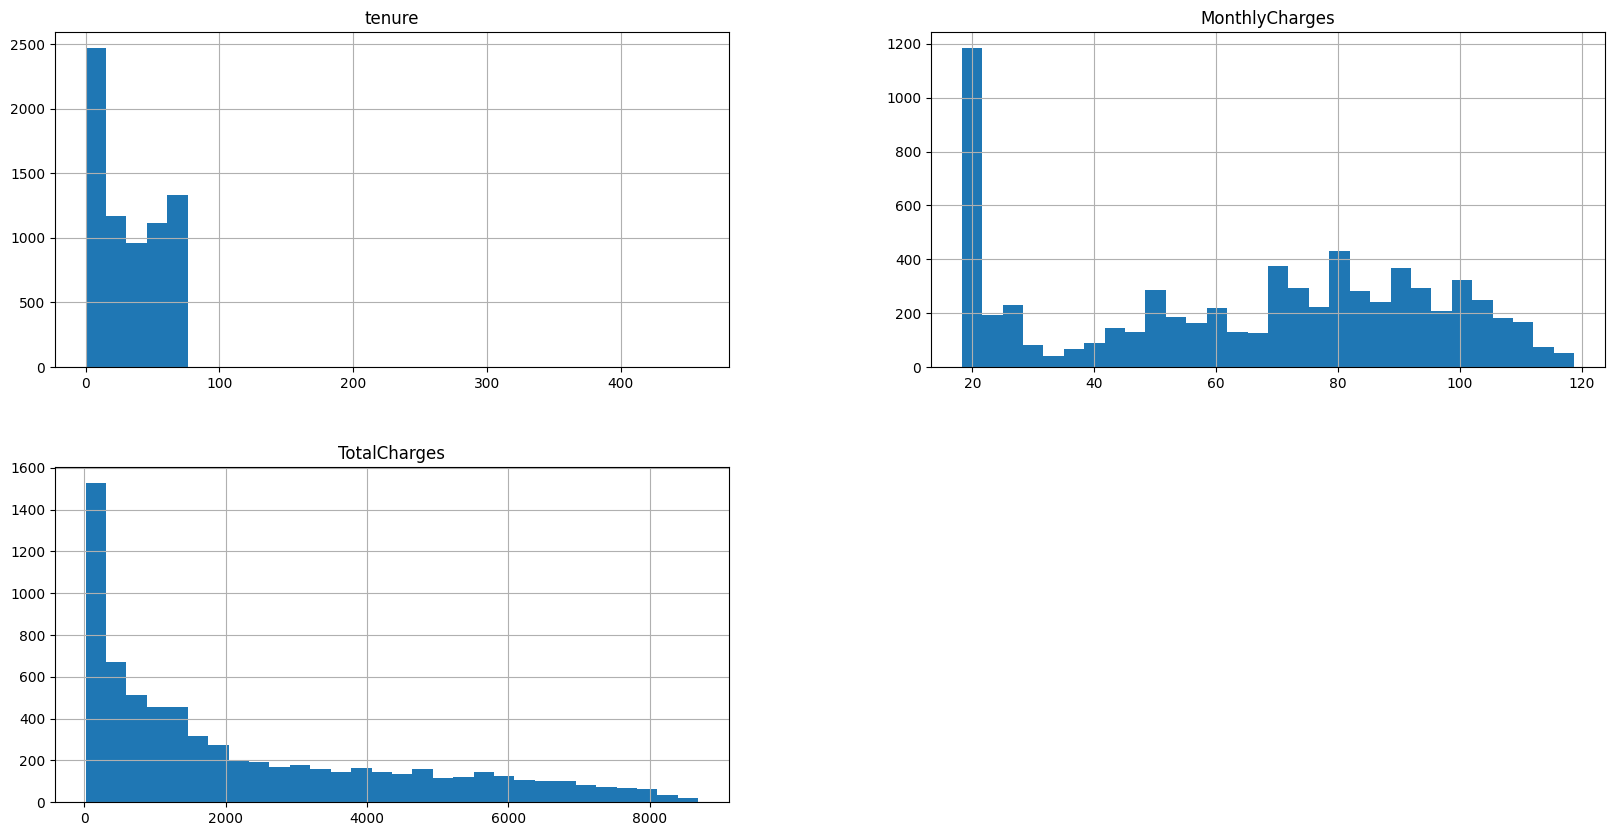

In [18]:
fig=plt.figure(figsize=(20,10))
ax=fig.gca()
df.hist(ax=ax,bins=30)
df.tenure.describe()

Let's generate the correlation matrix 

In [19]:
df.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.806530
MonthlyCharges,0.243703,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


Let's check the unique value count per each categorical variables

In [20]:
categorical_features

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [21]:
data.select("Contract").show()

+--------------+
|      Contract|
+--------------+
|Month-to-month|
|      One year|
|Month-to-month|
|      One year|
|Month-to-month|
|Month-to-month|
|Month-to-month|
|Month-to-month|
|Month-to-month|
|      One year|
|Month-to-month|
|      Two year|
|      One year|
|Month-to-month|
|Month-to-month|
|      Two year|
|      One year|
|      Two year|
|Month-to-month|
|Month-to-month|
+--------------+
only showing top 20 rows



In [22]:
for columns in categorical_features:
    data.groupBy(columns).count().show()


+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682

Let's find number of null values in all of our dataframe columns

In [23]:
data.select(count(col("Churn"))).show()

+------------+
|count(Churn)|
+------------+
|        7043|
+------------+



In [24]:
data.select("Churn").distinct().show()

+-----+
|Churn|
+-----+
|   No|
|  Yes|
+-----+



In [25]:
data.select(count(when(col("Churn").isNull(),'Churn'))).show()

+-----------------------------------------------+
|count(CASE WHEN (Churn IS NULL) THEN Churn END)|
+-----------------------------------------------+
|                                              0|
+-----------------------------------------------+



In [26]:
data.select(count(when(col("Churn").isNull(),'Churn')).alias('Churn')).show()

+-----+
|Churn|
+-----+
|    0|
+-----+



In [27]:
for columns in categorical_features:
    data.select(count(when(col(columns).isNull(),columns)).alias(columns)).show()

+----------+
|customerID|
+----------+
|         0|
+----------+

+------+
|gender|
+------+
|     0|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            0|
+-------------+

+-------+
|Partner|
+-------+
|      0|
+-------+

+----------+
|Dependents|
+----------+
|         0|
+----------+

+------------+
|PhoneService|
+------------+
|           0|
+------------+

+-------------+
|MultipleLines|
+-------------+
|            0|
+-------------+

+---------------+
|InternetService|
+---------------+
|              0|
+---------------+

+--------------+
|OnlineSecurity|
+--------------+
|             0|
+--------------+

+------------+
|OnlineBackup|
+------------+
|           0|
+------------+

+----------------+
|DeviceProtection|
+----------------+
|               0|
+----------------+

+-----------+
|TechSupport|
+-----------+
|          0|
+-----------+

+-----------+
|StreamingTV|
+-----------+
|          0|
+-----------+

+---------------+
|StreamingMovies|
+-----

### **Task 3 - Data Preprocessing**
- Handling the missing values
- Removing the outliers

**Handling the missing values** <br>
Let's create a list of column names with missing values

In [28]:
columns_with_null_values = [columns for columns in categorical_features if data.where(col(columns).isNull()).count() > 0]

In [29]:
columns_with_null_values=['TotalCharges']

Creating our Imputer

In [30]:
imputer=Imputer(inputCols=columns_with_null_values,outputCols=columns_with_null_values).setStrategy("mean")

Use Imputer to fill the missing values

In [31]:
if columns_with_null_values:
	imputer = Imputer(inputCols=columns_with_null_values, outputCols=columns_with_null_values).setStrategy("mean")
	imputer = imputer.fit(data)
	data = imputer.transform(data)
else:
	print("No columns with null values found.")

Let's check the missing value counts again

In [32]:
data.select(count(when(col("TotalCharges").isNull(),'TotalCharges'))).show()

+-------------------------------------------------------------+
|count(CASE WHEN (TotalCharges IS NULL) THEN TotalCharges END)|
+-------------------------------------------------------------+
|                                                            0|
+-------------------------------------------------------------+



**Removing the outliers** <br>
Let's find the customer with the tenure higher than 100 

In [33]:
data.select("*").where(data.tenure>100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

Let's drop the outlier row

In [34]:
print("Number of rows before filtering out outliers: ", data.count())
data = data.filter(data.tenure <= 100)
print("Number of rows after filtering out outliers: ", data.count())

Number of rows before filtering out outliers:  7043
Number of rows after filtering out outliers:  7042


### **Task 4 - Feature Preparation**
- Numerical Features 
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors




**Feature Preparation - Numerical Features** <br>

`Vector Assembling --> Standard Scaling` <br>

**Vector Assembling** <br>
To apply our machine learning model we need to combine all of our numerical and categorical features into vectors. For now let's create a feature vector for our numerical columns.


In [35]:
numerical_vector_assembler = VectorAssembler(inputCols=numerical_features, outputCol="numerical_features_vector")
data=numerical_vector_assembler.transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service

**Numerical Scaling** <br>
Let's standardize all of our numerical features. 

In [36]:
scaler=StandardScaler(inputCol="numerical_features_vector",outputCol="scaled_numerical_features_vector",withStd=True,withMean=True)
data=scaler.fit(data).transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+--------------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|scaled_numerical_features_vector|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-----------------------

**Feature Preperation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

In [37]:
categorical_features

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [38]:
categorical_features_indexer = [name + "_index" for name in categorical_features]

In [39]:
categorical_features_indexer

['customerID_index',
 'gender_index',
 'SeniorCitizen_index',
 'Partner_index',
 'Dependents_index',
 'PhoneService_index',
 'MultipleLines_index',
 'InternetService_index',
 'OnlineSecurity_index',
 'OnlineBackup_index',
 'DeviceProtection_index',
 'TechSupport_index',
 'StreamingTV_index',
 'StreamingMovies_index',
 'Contract_index',
 'PaperlessBilling_index',
 'PaymentMethod_index',
 'Churn_index']

In [40]:
indexer = StringIndexer(inputCols=categorical_features, outputCols=categorical_features_indexer)
data = indexer.fit(data).transform(data)
data.show(5)

24/11/26 19:31:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+--------------------------------+----------------+------------+-------------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+-----------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|scaled_numerical_features_v

In [41]:
categorical_features_indexer.remove("Churn_index")
categorical_features_indexer.remove("customerID_index")

Let's combine all of our categorifal features in to one feature vector.

In [42]:
categorical_vector_assembler = VectorAssembler(inputCols=categorical_features_indexer, outputCol="categorical_features_vector")
data = categorical_vector_assembler.transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+--------------------------------+----------------+------------+-------------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+-----------+---------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector

Now let's combine categorical and numerical feature vectors.

In [ ]:
final_vector_assembler = VectorAssembler(inputCols=["scaled_numerical_features_vector", "categorical_features_vector"], outputCol="Final_features_vectors")
data = final_vector_assembler.transform(data)

data.select(["Final_features_vectors","Churn_index"]).show(5)

+----------------------+-----------+
|Final_features_vectors|Churn_index|
+----------------------+-----------+
|  (19,[0,1,2,3,5,7,...|        0.0|
|  (19,[0,1,2,9,10,1...|        0.0|
|  (19,[0,1,2,9,10,1...|        1.0|
|  [0.51406079695460...|        0.0|
|  (19,[0,1,2,3],[-1...|        1.0|
+----------------------+-----------+
only showing top 5 rows



In [44]:
from pyspark.ml.linalg import VectorUDT

data.printSchema()  # Verifica los tipos de las columnas

# Si alguna columna no es del tipo VectorUDT, deberías asegurarte de transformarlas adecuadamente


root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- numerical_features_vector: vector (nullable = true)
 |-- scaled_numerical_feat

### **Task 5 - Model Training**
- Train and Test data splitting 
- Creating our model 
- Training our model 
- Make initial predictions using our model

In this task, we are going to start training our model

In [45]:
train, test = data.randomSplit([0.7, 0.3],seed=100)
train.count(), test.count()

(4930, 2112)

Now let's create and train our desicion tree

In [46]:
train.show(10)

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+--------------------------------+----------------+------------+-------------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+-----------+---------------------------+----------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerica

In [47]:
dt=DecisionTreeClassifier(featuresCol="Final_features_vectors",labelCol="Churn_index",maxDepth=3)
model=dt.fit(train)

Let's make predictions on our test data

In [48]:
predictions_test=model.transform(test)
predictions_test.select("churn","Churn_index","prediction").show(10)

+-----+-----------+----------+
|churn|Churn_index|prediction|
+-----+-----------+----------+
|  Yes|        1.0|       1.0|
|   No|        0.0|       0.0|
|   No|        0.0|       0.0|
|   No|        0.0|       0.0|
|   No|        0.0|       0.0|
|  Yes|        1.0|       0.0|
|   No|        0.0|       0.0|
|  Yes|        1.0|       0.0|
|   No|        0.0|       0.0|
|   No|        0.0|       0.0|
+-----+-----------+----------+
only showing top 10 rows



### **Task 6 - Model Evaluation**
- Calculating area under the ROC curve for the `test` set 
- Calculating area under the ROC curve for the `training` set 
- Hyper parameter tuning

In [49]:
evaluator=BinaryClassificationEvaluator(labelCol="Churn_index",metricName="areaUnderROC")
auc_test=evaluator.evaluate(predictions_test,{evaluator.metricName:"areaUnderROC"})
auc_test

0.7678230877272001

Let's get the AUC for our `training` set

In [50]:
predictions_train=model.transform(train)
auc_train=evaluator.evaluate(predictions_train,{evaluator.metricName:"areaUnderROC"})
auc_train

0.7721112330375414

**Hyper parameter tuning**

Let's find the best `maxDepth` parameter for our DT model. 

In [ ]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'Final_features_vectors', labelCol = 'Churn_index', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_index")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_index")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)

Let's define `params` list to evaluate our model iteratively with differe maxDepth parameter.  

In [54]:
maxDepths = [3, 5, 7, 9, 11, 13, 15,17,19,21]
test_accuracies, train_accuracies = evaluate_dt(maxDepths)
print(test_accuracies)
print(train_accuracies)

[0.7678230877272001, 0.5664944085244075, 0.7459929239831928, 0.7386656315374632, 0.7710641878878031, 0.7483486330960832, 0.718568321490586, 0.7003988408133272, 0.6919692542921316, 0.683878652830703]
[0.7721112330375414, 0.5647403286677019, 0.7600923189684357, 0.785827435281247, 0.8631097062703353, 0.9232336695945687, 0.9524972983474892, 0.9768541758042003, 0.9863893831727073, 0.9903592072150799]


Let's visualize our results

In [55]:
df=pd.DataFrame()
df['maxDepths']=maxDepths
df['test_accuracies']=test_accuracies
df['train_accuracies']=train_accuracies
px.line(df,x='maxDepths',y=['test_accuracies','train_accuracies'],title='Test and Train AUC vs Max Depth')

### **7 - Model Deployment**
- Giving Recommendations using our model 



We were asked to recommend a solution to reduce the customer churn. 


In [62]:
feature_importance = model.featureImportances
scores = [score for i ,score in enumerate(feature_importance)]
df=pd.DataFrame(scores,columns=['score'],index=categorical_features_indexer+numerical_features)
px.bar(df,y='score')

Let's create a bar chart to visualize the customer churn per contract type

In [63]:
df=data.groupBy(["Contract","Churn"]).count().toPandas()
px.bar(df,x='Contract',y='count',color='Churn',title='Churn vs Contract')

The bar chart displays the number of churned customers based on their contract type. It is evident that customers with a "Month-to-month" contract have a higher churn rate compared to those with "One year" or "Two year" contracts. As a recommendation, the telecommunication company could consider offering incentives or discounts to encourage customers with month-to-month contracts to switch to longer-term contracts. 